In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import folium as fl
import seaborn as sns
import pylab as plt
from IPython.display import HTML
import rasterio
import rasterstats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from rasterio.plot import show, show_hist
from rasterstats import point_query, zonal_stats

#import mplleaflet as mpll
% pylab inline

UsageError: Line magic function `%` not found.


# Harnessing open data to build support for pollution-free cities

This notebook accompanies my Medium post (link).
We will:
* Import an air pollution raster and a shapefile of NYC schools
* Get the average schoolyard pollution levels since 2009
* Visualize the quality of air quality that kids are exposed to
* Identify the most hazardous schools and boroughs

#### 1. Import pollution rasters and school locations

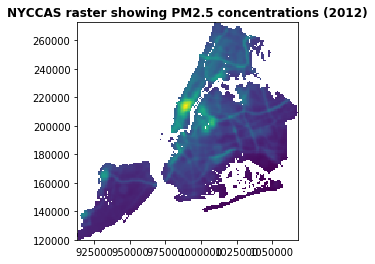

In [2]:
raster_PM25 = rasterio.open("data/AnnAvg1_8_300mSurfaces/aa3_pm300m//")

# Or download from NYC Open Data: https://data.cityofnewyork.us/Environment/NYCCAS-Air-Pollution-Rasters/q68s-8qxv

show(raster_PM25,title = 'NYCCAS raster showing PM2.5 concentrations (2012)');

In [3]:
df_schools = gp.GeoDataFrame.from_file('data/schools_download/schools_download.shp')

# Or download from NYC Open Data: https://data.cityofnewyork.us/Education/2017-2018-School-Locations/p6h4-mpyy

df_schools.head(3)

,BORO,SCHOOLNAME,SCH_TYPE,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,X,P.S. 007 KINGSBRIDGE,Elementary,3201 KINGSBRIDGE AVENUE,NY,10463,Frank Patterson,718-796-8695,718-796-7204,"0K,01,02,03,04,05,SE",BRONX,POINT (1010369.065062717 260392.863812387)
1,X,P.S. 008 ISSAC VARIAN,Elementary,3010 BRIGGS AVENUE,NY,10458,ROSA MARIA PERALTA,718-584-3043,718-584-7376,"0K,01,02,03,04,05,SE",BRONX,POINT (1016483.720641196 257160.2885755301)
2,X,P.S. 016 WAKEFIELD,Elementary,4550 CARPENTER AVENUE,NY,10470,YVONNE WILLIAMS,718-324-1262,718-324-8370,"PK,0K,01,02,03,04,05,SE",BRONX,POINT (1024477.594875544 268049.4543402791)


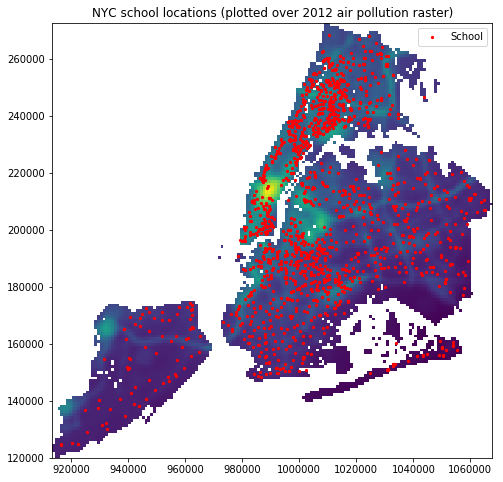

In [49]:
fig, ax = plt.subplots(figsize=[8,8])
show(raster_PM25, ax=ax)
df_schools.plot(ax=ax,color='r',markersize=5,label='School')
plt.legend()
plt.title('NYC school locations (plotted over 2012 air pollution raster)');

#### 2. Sample pollution at school locations

In [13]:
from rasterstats import point_query

shp = 'data/schools_download/schools_download.shp'
rast = "data/AnnAvg1_8_300mSurfaces/aa3_pm300m//"
df_schools['PM25_2012'] = point_query(shp, rast)

In [14]:
df_schools.head(3)

,BORO,SCHOOLNAME,SCH_TYPE,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry,PM25_2012
0,X,P.S. 007 KINGSBRIDGE,Elementary,3201 KINGSBRIDGE AVENUE,NY,10463,Frank Patterson,718-796-8695,718-796-7204,"0K,01,02,03,04,05,SE",BRONX,POINT (1010369.065062717 260392.863812387),11.377123
1,X,P.S. 008 ISSAC VARIAN,Elementary,3010 BRIGGS AVENUE,NY,10458,ROSA MARIA PERALTA,718-584-3043,718-584-7376,"0K,01,02,03,04,05,SE",BRONX,POINT (1016483.720641196 257160.2885755301),10.841334
2,X,P.S. 016 WAKEFIELD,Elementary,4550 CARPENTER AVENUE,NY,10470,YVONNE WILLIAMS,718-324-1262,718-324-8370,"PK,0K,01,02,03,04,05,SE",BRONX,POINT (1024477.594875544 268049.4543402791),10.398079


#### 3. Clean the dataset

In [27]:
#Import the full dataframe with PM2.5 for seven years (prepared earlier)

df = gp.GeoDataFrame.from_file('data/schools_PM25')

In [28]:
# Tidy up the column names
df.rename(columns = {'BORO': 'borough','SCHOOLNAME':'school_name','SCH_TYPE':'sch_type','PRINCIPAL':'principal',
                    'PRIN_PH':'principal_phone','GRADES':'grades'},inplace=True)

In [29]:
# Which school types are included?

print(df.sch_type.value_counts())

Elementary                         612
High school                        396
Junior High-Intermediate-Middle    273
K-8                                165
Secondary School                    94
K-12 all grades                     54
Early Childhood                     34
Ungraded                             1
Name: sch_type, dtype: int64


In [31]:
# Drop schools where borough is marked as None

print("Number of schools: {}".format(df.shape[0]))
df = df[df.borough.notnull()]
print("Number of schools after cleaning: {}".format(df.shape[0]))

# Focus on four boroughs leaving Staten Island out for now
df = df[df.borough != 'R']

Number of schools: 1613
Number of schools after cleaning: 1613


In [32]:
# NYC uses one-letter codes for its boroughs. Replace these with the full borough names.

df.borough.replace({'K':'Brooklyn', 'X': 'Bronx','Q':'Queens','M':'Manhattan'},inplace=True)

#### 4. Exploratory plots

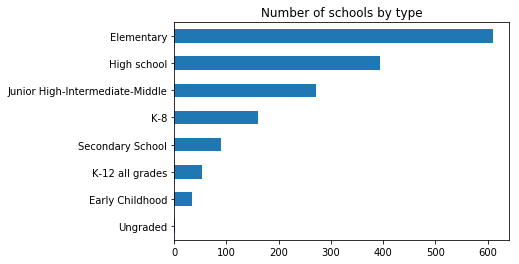

In [33]:
#  School types in chart form

df.sch_type.value_counts().plot(kind="barh",title="Number of schools by type").invert_yaxis();

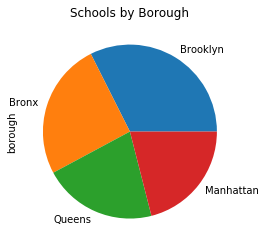

In [35]:
# Breakdown of schools by borough

df.borough.value_counts().plot(kind="pie",title="Schools by Borough");

## ANALYSIS

#### 5. How does air quality differ by borough?
* How many schools have hazardous air quality (PM2.5 > 10)?

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


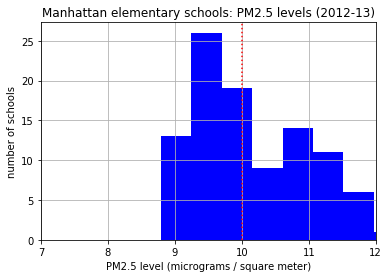

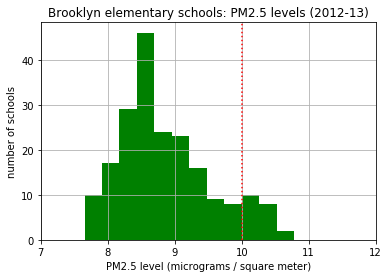

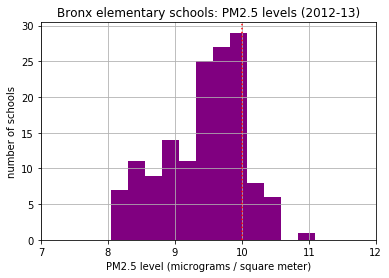

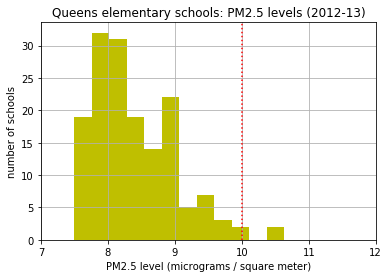

In [36]:
# Histogram of 2012 PM2.5 values for elementary schools by borough

boroughs = ['Manhattan','Brooklyn','Bronx','Queens']
cols = ['b','g','purple','y']

for n, borough in enumerate(boroughs):       

    f,ax = plt.subplots(1,figsize=[6,4])
    df[(df.sch_type == 'Elementary') & (df.borough == borough)].pm_5.hist(ax=ax,color=cols[n],bins=12)
    plt.title(borough + " elementary schools: PM2.5 levels (2012-13)")
    plt.xlabel("PM2.5 level (micrograms / square meter)")
    plt.ylabel("number of schools")
    plt.xlim(7,12)
    plt.axvline(x=10,linestyle='dotted',color='r');

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


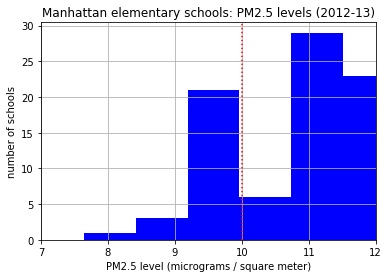

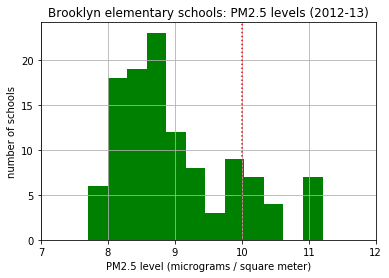

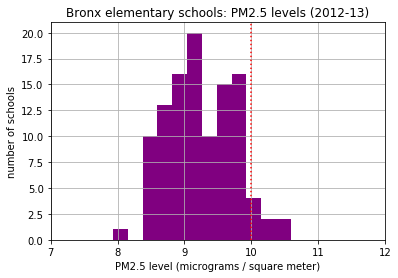

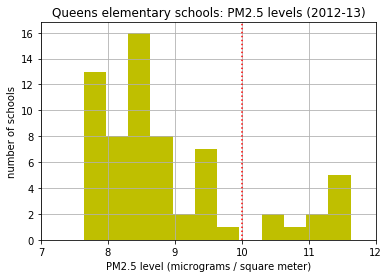

In [37]:
# Histogram of 2012 PM2.5 values for high schools by borough

boroughs = ['Manhattan','Brooklyn','Bronx','Queens']
cols = ['b','g','purple','y']

for n, borough in enumerate(boroughs):       

    f,ax = plt.subplots(1,figsize=[6,4])
    df[df.sch_type=='High school'][df.borough==borough].pm_5.hist(ax=ax,color=cols[n],bins=12)
    plt.title(borough+" elementary schools: PM2.5 levels (2012-13)");
    plt.xlabel("PM2.5 level (micrograms / square meter)")
    plt.ylabel("number of schools")
    plt.xlim(7,12)
    plt.axvline(x=10,linestyle='dotted',color='r');

#### 6. Did PM2.5 levels improve in the past 7 years?

In [38]:
# Use the Pandas groupby function to get mean PM2.5 by year, by borough

boro_means = pd.DataFrame(df.groupby('borough').mean())[['pm_1', 'pm_2', 'pm_3', 'pm_4', 'pm_5', 'pm_6', 'pm_7']]
boro_means.rename(columns={'pm_1':'2008-9','pm_2':'2009-10','pm_3':'2010-11','pm_4':'2011-12','pm_5':'2012-13',
                           'pm_6':'2013-14','pm_7':'2014-15'},inplace=True)
boro_means = boro_means.T
boro_means

borough,Bronx,Brooklyn,Manhattan,Queens
2008-9,11.349018,10.745911,12.260142,10.209581
2009-10,10.506200,9.918334,11.208129,9.349096
2010-11,11.021388,10.345536,11.641777,9.905475
2011-12,9.815684,9.207479,10.638152,8.750289
2012-13,9.354558,8.895129,10.640834,8.488052
2013-14,9.497390,9.275470,10.516039,8.736600
2014-15,9.358374,8.953080,9.970283,8.444678


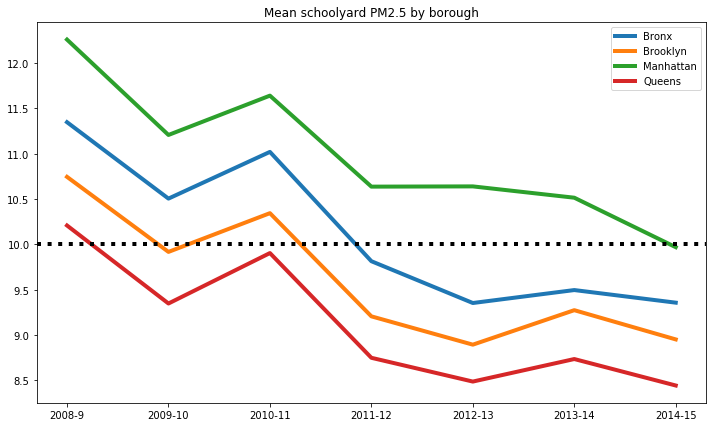

In [42]:
fig,ax=plt.subplots(figsize=[12,7])
for i in boro_means.columns:
    plt.plot(boro_means[i],label=i,linewidth = 4)
ax.set_title("Mean schoolyard PM2.5 by borough")
plt.legend()
plt.axhline(y=10,linestyle='dotted',color='k',linewidth = 4);

Conclusion: Yes, PM2.5 levels have fallen.

#### 7. Are PM2.5 levels correlated with poverty?
* answer: at first glance, it doesn't appear so.
* expensive schools in Manhattan are near a lot of traffic. (A similar story to London.)
* though Bronx has some linear relationship

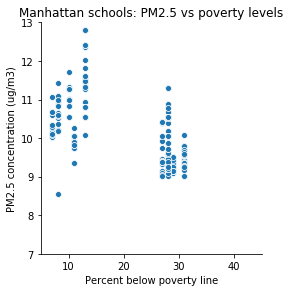

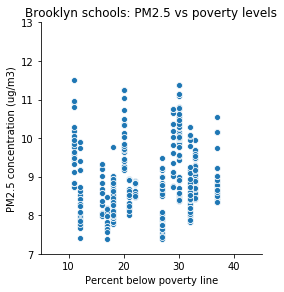

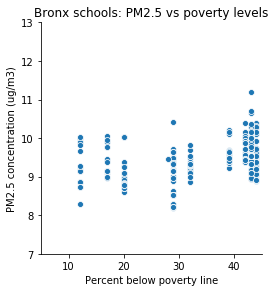

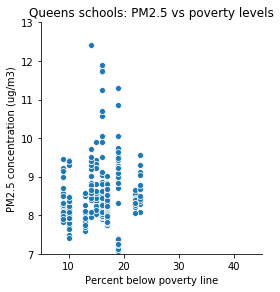

In [119]:
for borough in boroughs:
    sns.pairplot(x_vars='Poverty',y_vars='pm_7',data=df[df.borough==borough],height=4)
    plt.title(borough+' schools: PM2.5 vs poverty levels')
    plt.xlabel('Percent below poverty line')
    plt.xlim(5,45)
    plt.ylim(7,13)
    plt.ylabel('PM2.5 concentration (ug/m3)');

Conclusion: No systematic relationship. Air pollution is an equal opportunities killer.

#### 8. So which schools have the worst air quality?

Text(0.5,1,'Elementary Schools by PM2.5 exposure')

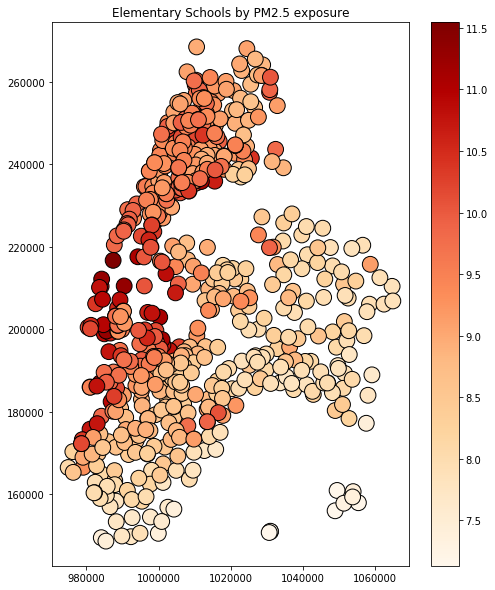

In [29]:
fig, ax = plt.subplots(figsize=(8,10))
df[df.sch_type=='Elementary'].plot(ax=ax,column='pm_7', cmap='OrRd', edgecolor='k', legend=True,markersize=250)
plt.title("Elementary Schools by PM2.5 exposure")

#### 8.1 Show on a scrollable map
* use mplleaflet, a library to provide Leaflet (javascript) visualizations in Jupyter Notebooks
* allows a quick proof of concept for a proper web-based visualization (eg. with Javascript D3)
* purpose: to discover how bad the air quality is in your neighborhood and get parents motivated to do something about it.

In [48]:
fig, ax = plt.subplots(1, figsize=(8,10))
df[df.sch_type=='Elementary'].plot(ax=ax,column='pm_7', cmap='OrRd', edgecolor='k', legend=True,markersize=250)
mpll.display(fig=ax.figure, crs=df.crs, tiles='cartodb_positron')

/anaconda3/envs/geo5/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### 8.2 Show the 10 schools with highest PM2.5, with contact details
* City data portals make a great deal of information (like school contact details) easy to access
* Similar info could be include as hover-over or pop-up data on the map

In [115]:
df[['school_name','principal','principal_phone','pm_7']][(df.sch_type=="Elementary") & (df.pm_7 > 10)].sort_values(by = 'pm_7',ascending = False).head()

,school_name,principal,principal_phone,pm_7
602,P.S. 212 MIDTOWN WEST,DEAN KETCHUM,212-247-0208,11.546577
588,P.S. 033 CHELSEA PREP,LINORE LINDY,212-244-6426,11.319379
595,P.S. 116 MARY LINDLEY MURRAY,JANE HSU,212-685-4366,11.316358
835,P.S. 124 YUNG WING,ALICE HOM,212-966-7237,11.300462
439,P.S. 062 INOCENSIO CASANOVA,LISA MANFREDONIA,718-585-1617,11.202111
